# GNNExplainer Experiment with BA-Shapes

**In this notebook:**
* Load BA-Shapes dataset according to https://github.com/flyingdoog/PGExplainer/blob/ec57ea2db3b196da7eb93179acffc64ec6958828/BA-shapes.ipynb
* Train GCN Model as described in https://arxiv.org/pdf/1903.03894.pdf
* Run GNNExplainer 
* Calculate accuracy of GNNExplainer

## Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx
from zipfile import ZipFile
from sklearn.metrics import roc_auc_score

from torch_geometric.nn import GCN
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse, to_networkx, k_hop_subgraph
from torch_geometric.nn import GNNExplainer
from torch_geometric.data.download import download_url

import torch

## Dataset

### Load Data

The dataset is loaded similar to: https://github.com/flyingdoog/PGExplainer/blob/ec57ea2db3b196da7eb93179acffc64ec6958828/BA-shapes.ipynb

In [2]:
url = "https://github.com/flyingdoog/PGExplainer/raw/ec57ea2db3b196da7eb93179acffc64ec6958828/dataset/datasets.zip"

In [3]:
folder = "data/BA-Shapes/"
path = download_url(url, folder)

with ZipFile(path, "r") as zf:
    zf.extractall(folder)

Using existing file datasets.zip


In [4]:
with open(folder + "syn1.pkl", "rb") as fin:
    (
        adj,
        features,
        y_train,
        y_val,
        y_test,
        train_mask,
        val_mask,
        test_mask,
        edge_label_matrix,
    ) = pickle.load(fin)

### Understand Data

I loaded the dataset but do not know what to find in adj, features, ... Therefore I check the variables and some properties to understand the data.

In [5]:
print("Features")
print("Value Counts: ", np.unique(features, return_counts=True))
print("Shape: ", np.shape(features))
print("There are 700 nodes and each of them has 10 features which are all 1s.")
print()


print("Adj:")
print("Value Counts: ", np.unique(adj, return_counts=True))
print("Shape: ", np.shape(adj))
print()

print("Y Train")
print("Value Counts: ", np.unique(y_train, return_counts=True))
print("Shape: ", np.shape(y_train))
print("Therefore there are 4 different classes, corresponding to"
      "nodes at the top, middle, bottom of houses, and nodes "
      "that do not belong to a house.")
print()

print("Node Distribution:")
print("Train Mask Value Counts: ", np.unique(train_mask, return_counts=True))
print("Val Mask Value Counts: ", np.unique(val_mask, return_counts=True))
print("Test Mask Value Counts: ", np.unique(test_mask, return_counts=True))
print("In total there are 700 examples splittet in 10% val/test & 80% train. ")
print()

print("Ys")
print("Ys are either stored in y_train, y_val or y_test")
print("train: ", y_train[0], "val: ", y_val[0], "test: ", y_test[0])
print("We put those together in all_label:")
all_label = np.logical_or(y_train, np.logical_or(y_val, y_test))
print("Value Counts: ", np.unique(all_label, return_counts=True))
print("Shape: ", all_label.shape)
print()

# Edge labels
print("Edge Label Matrix")
print("Shape: ", edge_label_matrix.shape)
print("Value Counts: ", np.unique(edge_label_matrix, return_counts=True))
print()

Features
Value Counts:  (array([1.]), array([7000]))
Shape:  (700, 10)
There are 700 nodes and each of them has 10 features which are all 1s.

Adj:
Value Counts:  (array([0., 1.]), array([485890,   4110]))
Shape:  (700, 700)

Y Train
Value Counts:  (array([0., 1.]), array([2240,  560]))
Shape:  (700, 4)
Therefore there are 4 different classes, corresponding tonodes at the top, middle, bottom of houses, and nodes that do not belong to a house.

Node Distribution:
Train Mask Value Counts:  (array([False,  True]), array([140, 560]))
Val Mask Value Counts:  (array([False,  True]), array([630,  70]))
Test Mask Value Counts:  (array([False,  True]), array([630,  70]))
In total there are 700 examples splittet in 10% val/test & 80% train. 

Ys
Ys are either stored in y_train, y_val or y_test
train:  [1. 0. 0. 0.] val:  [0. 0. 0. 0.] test:  [0. 0. 0. 0.]
We put those together in all_label:
Value Counts:  (array([False,  True]), array([2100,  700]))
Shape:  (700, 4)

Edge Label Matrix
Shape:  (7

In [6]:
edge_index = dense_to_sparse(torch.tensor(adj))[0]
dataset = Data(
    x=torch.tensor(features, dtype=torch.double),
    edge_index=edge_index,
    y=torch.argmax(torch.tensor(all_label).double(), axis=1),
    edge_label=edge_label_matrix,
)

In [7]:
dataset.x.shape, dataset.edge_index.max(), dataset.edge_label.shape

(torch.Size([700, 10]), tensor(699), (700, 700))

### Visualize Data

Vizualise 3 hop subgraph of node 600.

In [8]:
# Subgraph of node 600
node_idx = 600
hop_subgraph = k_hop_subgraph(node_idx, 3, dataset.edge_index)
# Map edges to new index space
sub_edge_index = [
    [hop_subgraph[0].tolist().index(j) for j in i] for i in hop_subgraph[1].tolist()
]
sub_x = dataset.x[hop_subgraph[0]]
sub_node_idx = hop_subgraph[2]

# Create PyG Data
subgraph = Data(
    x=sub_x,
    edge_index=torch.tensor(sub_edge_index),
    y=torch.tensor(dataset.y[hop_subgraph[0]].cpu().numpy()),
    edge_label=dataset.edge_label[hop_subgraph[0]][:, hop_subgraph[0]],
)

In [9]:
nx_graph = to_networkx(subgraph)
for i in list(nx_graph.nodes):
    nx_graph.nodes[i]["group"] = subgraph.y.tolist()[i]

for edge in nx_graph.edges:
    nx_graph.edges[edge]["value"] = 1 + 5 * subgraph.edge_label[edge[0], edge[1]]

net = Network(notebook=True)
net.from_nx(nx_graph)
net.show("viz.html")

I assume that the two yellow nodes also belong to houses, but the missing nodes are not in the subgraph (k hops graph) anymore.

## GCN Model

As describes in the paper we use a 3 layer GCN with a hidden dimension of 20. 

In [10]:
model = GCN(features.shape[1], 20, 3, y_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).double()
dataset = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()

train_ids = np.where(np.sum(y_train, axis=1) == 1)[0]
test_ids = np.where(np.sum(y_test, axis=1) == 1)[0]
val_ids = np.where(np.sum(y_val, axis=1) == 1)[0]

target = torch.argmax(torch.tensor(y_train[train_ids]), dim=1).to(device)
target_test = y_train[test_ids]
target_val = y_train[val_ids]

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(dataset.x.double(), dataset.edge_index)

    out_train = out[train_ids]
    out_val = out[val_ids]
    out_test = out[test_ids]

    train_loss = torch.nn.functional.cross_entropy(out_train, dataset.y[train_ids])

    train_correct = (out_train.argmax(dim=1) == dataset.y[train_ids]).sum()
    acc = train_correct / len(train_ids)
    test_correct = (out_test.argmax(dim=1) == dataset.y[test_ids]).sum()
    test_acc = test_correct / len(test_ids)
    val_correct = (out_val.argmax(dim=1) == dataset.y[val_ids]).sum()
    val_acc = val_correct / len(val_ids)

    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Train Accuracy: {acc}, Test Accuracy: {test_acc}, Val Accuracy: {val_acc}"
        )

Train Accuracy: 0.24821428954601288, Test Accuracy: 0.24285714328289032, Val Accuracy: 0.12857143580913544
Train Accuracy: 0.7535714507102966, Test Accuracy: 0.7142857313156128, Val Accuracy: 0.7857142686843872
Train Accuracy: 0.9624999761581421, Test Accuracy: 0.9714285731315613, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9339285492897034, Test Accuracy: 0.8999999761581421, Val Accuracy: 0.9285714626312256
Train Accuracy: 0.9571428894996643, Test Accuracy: 0.9285714626312256, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9624999761581421, Test Accuracy: 0.9571428894996643, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9642857313156128, Test Accuracy: 0.9428571462631226, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9624999761581421, Test Accuracy: 0.9285714626312256, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9678571224212646, Test Accuracy: 0.9571428894996643, Val Accuracy: 0.985714316368103
Train Accuracy: 0.9607142806053162, Test Accuracy: 0.95714288949966

Those results are similar to the one reported in the original GNNExplainer Paper. Ying et al. achieve an node classification accuracy of around 95%. 

## GNNExplainer

### Train GNNExplainer for One Instance

For the subgraph created in Understand Data, we try to find the important edges with GNNExplainer.

In [12]:
explainer = GNNExplainer(model, epochs=200, return_type="log_prob")
subgraph = subgraph.to(device)

We wanna explain node: 108.


Explain node tensor([108]): 100%|██████████| 200/200 [00:01<00:00, 119.90it/s]


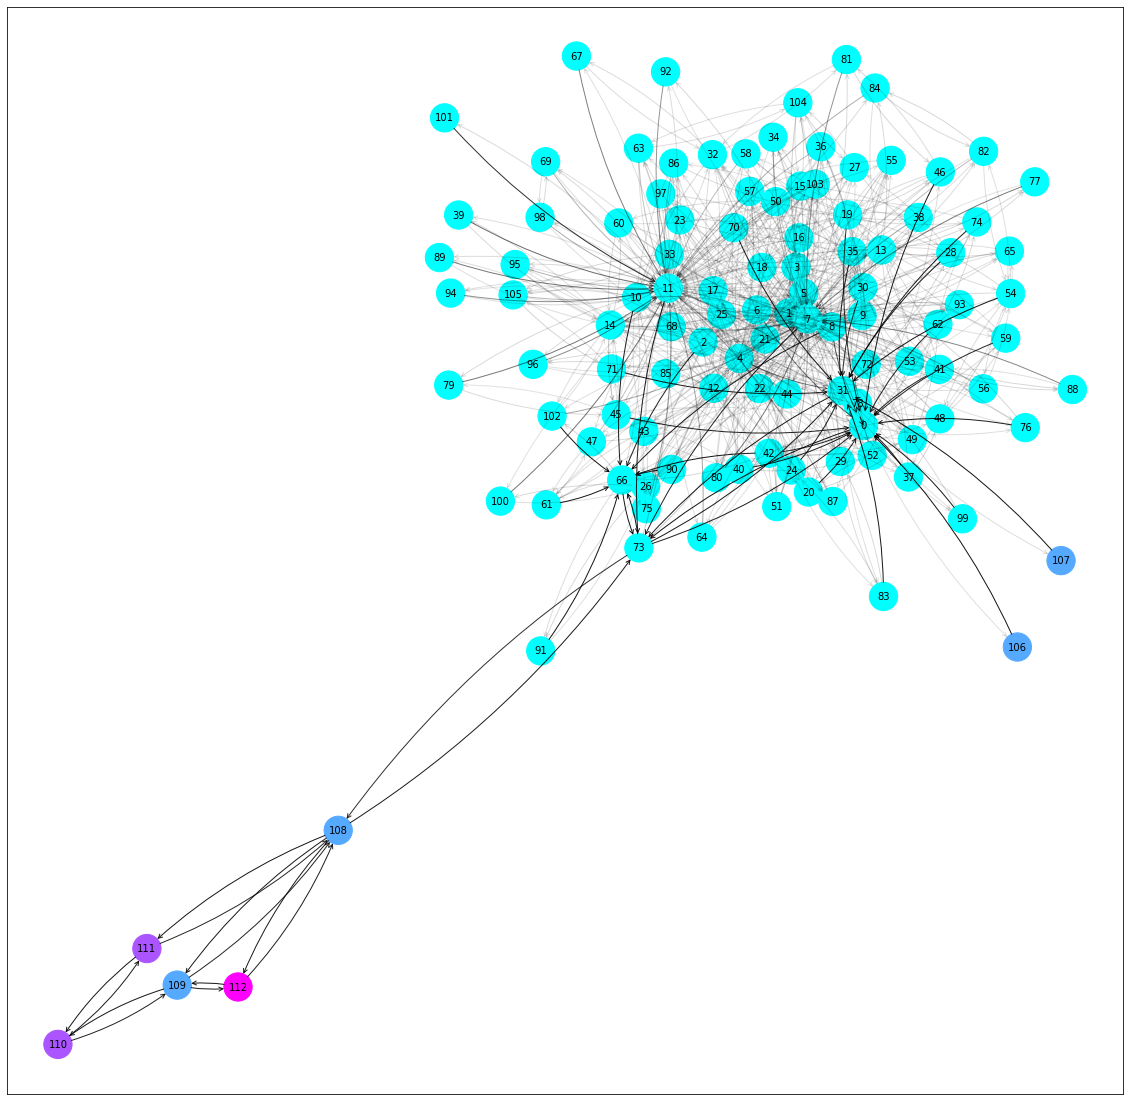

In [13]:
plt.figure(figsize=(20, 20))
print(f"We wanna explain node: {sub_node_idx.item()}.")
node_feat_mask, edge_mask = explainer.explain_node(
    sub_node_idx, subgraph.x, subgraph.edge_index
)
ax, G = explainer.visualize_subgraph(
    sub_node_idx, subgraph.edge_index, edge_mask, y=subgraph.y
)

plt.show()

In [14]:
edge_mask

tensor([0.1437, 0.1447, 0.1334, 0.1314, 0.1424, 0.1467, 0.1307, 0.1326, 0.1282,
        0.1192, 0.1368, 0.1424, 0.1341, 0.9178, 0.1308, 0.1282, 0.1309, 0.1268,
        0.1453, 0.1199, 0.1593, 0.1266, 0.1212, 0.1534, 0.1477, 0.1366, 0.1354,
        0.1393, 0.1389, 0.1337, 0.1301, 0.1386, 0.1408, 0.1264, 0.1533, 0.1325,
        0.1316, 0.1357, 0.1219, 0.1402, 0.1389, 0.1303, 0.1308, 0.1345, 0.1273,
        0.1244, 0.8704, 0.1486, 0.1339, 0.1470, 0.1428, 0.1396, 0.1584, 0.1404,
        0.1453, 0.1617, 0.1305, 0.1317, 0.1579, 0.1310, 0.1495, 0.1503, 0.1300,
        0.1437, 0.1229, 0.1305, 0.1324, 0.1482, 0.2158, 0.1313, 0.1343, 0.1564,
        0.1471, 0.1427, 0.1311, 0.1350, 0.1393, 0.1278, 0.1326, 0.1201, 0.1247,
        0.1346, 0.1204, 0.1252, 0.5130, 0.1369, 0.1307, 0.1348, 0.1367, 0.1251,
        0.1650, 0.1281, 0.1416, 0.1268, 0.1206, 0.1251, 0.1143, 0.1344, 0.1291,
        0.1228, 0.1430, 0.1336, 0.1488, 0.1323, 0.1506, 0.1455, 0.1476, 0.1348,
        0.1318, 0.1385, 0.1247, 0.1239, 

### Accuracy for All Nodes

For every node we can extract the subgraph and evaluate the importance of each edge in the subgraph according to the edge label matrix. [Ying et al.](https://arxiv.org/pdf/1903.03894.pdf) report in their paper an explanation accuracy of 92.5%.

According to the function explain nodes gnn stats: https://github.com/RexYing/gnn-model-explainer/blob/bc984829f4f4829e93c760e9bbdc8e73f96e2cc1/explainer/explain.py#L328

In [15]:
def extract_subgraph(node_idx, x, edge_index, edge_label):
    subgraph = k_hop_subgraph(node_idx, 3, edge_index)
    sub_edge_index = [
        [subgraph[0].tolist().index(j) for j in i] for i in subgraph[1].tolist()
    ]
    sub_x = x[subgraph[0]]
    sub_edge_label = edge_label[subgraph[0].cpu()][:, subgraph[0].cpu()]
    

    return sub_x, sub_edge_index, subgraph[2], sub_edge_label

In [16]:
# iterate over all nodes (same as in original paper: https://github.com/RexYing/gnn-model-explainer/blob/bc984829f4f4829e93c760e9bbdc8e73f96e2cc1/explainer_main.py#L311)
allnodes_idx = [i for i in range(400, 700, 5)]

aucs = []
for i in range(10):
    explainer = GNNExplainer(model, epochs=100, return_type="log_prob", log=False)
    all_preds = []
    all_targets = []
    for node_idx in allnodes_idx:
        # extract subgraph
        sub_x, sub_edge_index, new_node_idx, sub_edge_label = extract_subgraph(
            node_idx, dataset.x, dataset.edge_index, dataset.edge_label
        )

        # explain node in subgraph
        _, edge_mask = explainer.explain_node(
            new_node_idx, sub_x, torch.tensor(sub_edge_index).to(device)
        )


        # calculate accuracy - strange calculation
        targets = []
        preds = []
        edges = []
        for i, (row, col) in enumerate(np.array(sub_edge_index).T):
            if [col, row] not in edges:
                target = sub_edge_label[col, row] + sub_edge_label[row, col]
                targets.append(1 if target > 0 else 0)
                pred = edge_mask[i].item() + edge_mask[i].item()
                preds.append(pred)
            else:
                index = edges.index([col, row])
                pred = edge_mask[i].item() + edge_mask[i].item()
                edge_mask[index] += pred
            edges.append([row, col])


        auc = roc_auc_score(targets,preds)
        all_preds.extend(preds)
        all_targets.extend(targets)
        #print(f"Node: {node_idx}, AUC: {auc}")
        aucs.append(roc_auc_score(all_targets,all_preds))
    print(f"Run {i}: AUC: ", roc_auc_score(all_targets,all_preds))
print(f"Mean AUC {np.mean(aucs)} +- {np.std(aucs)}")


Run 491: AUC:  0.9191600638464011
Run 491: AUC:  0.9087839327545817
Run 491: AUC:  0.9183915529833264
Run 491: AUC:  0.9182734486243167
Run 491: AUC:  0.8970889026686877
Run 491: AUC:  0.9086488333103669
Run 491: AUC:  0.9047656860043176
Run 491: AUC:  0.9075496072757337
Run 491: AUC:  0.908553752698544
Mean AUC 0.9274160669583011 +- 0.020382341494513265


Open Questions: 
1. Why is it called accuracy in the paper even if it seems to be auc roc? 
2. Optimal is when the edge weight reaches 0.5 as it goes in two directions?
3. Subgraph looks different in PGExplainer: https://github.com/flyingdoog/PGExplainer/blob/ec57ea2db3b196da7eb93179acffc64ec6958828/BA-shapes.ipynb. 
4. Results seem to vary quite a little bit depending on the model.